<a href="https://www.kaggle.com/code/maorsagi/hdd-failure-2019?scriptVersionId=109722527" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import the required modules

In [16]:
!pip install git+https://github.com/goolig/dsClass.git
    

  Cloning https://github.com/goolig/dsClass.git to /tmp/pip-req-build-uphetfr7
  Running command git clone -q https://github.com/goolig/dsClass.git /tmp/pip-req-build-uphetfr7
  Created wheel for dsClass: filename=dsClass-1.0.27-cp36-none-any.whl size=16372735 sha256=f5f6064ae931dd0cd9c937c183ef4a275c85f5ca64609022ea292851954fd54f
  Stored in directory: /tmp/pip-ephem-wheel-cache-mo6ui7s8/wheels/c7/a9/03/023d8da4b4e004497715eeb1ea9b5d914ad425036bb4bc10b8
Successfully built dsClass


In [17]:

%matplotlib inline
#using different libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, f_classif, chi2, SelectKBest, SelectFpr
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support #metrics tell us about module accuracy

from dsClass.path_helper import *



# Load the time-series data and lookt at the features statistics

In [18]:
# static data
ts_file_path = get_file_path('ts_data.csv')
ts_data = pd.read_csv(ts_file_path)
print(ts_data.shape) #204000 samples, 9 fields
featured_data = ts_data
ts_data.head()# fetch 5 records
#warning - negative count?


(204000, 9)


,d_id,time,bb_count,r-w_rate,reconsects_count,recovbydrv_count,xfer_rate,bb_diffs,fail
0,1,V1,-5,14,0,9,85,0,True
1,1,V2,5,15,0,17,76,0,True
2,1,V3,14,11,0,24,87,0,True
3,1,V4,22,7,0,31,75,0,True
4,1,V5,29,11,0,42,81,0,True


In [19]:
ts_data.groupby('fail').describe() #statistics by 'fail' field (true,false - 2 rows)

#warning - statistics comparation between tow groups - present closed values

d_id                                                        \
          count    mean          std    min      25%     50%      75%   
fail                                                                    
False  200000.0  5200.5  2886.758548  201.0  2700.75  5200.5  7700.25   
True     4000.0   100.5    57.741523    1.0    50.75   100.5   150.25   

                bb_count              ... xfer_rate         bb_diffs           \
           max     count        mean  ...       75%    max     count     mean   
fail                                  ...                                       
False  10200.0  200000.0   97.986965  ...      83.0  148.0  200000.0  3.01709   
True     200.0    4000.0  122.358000  ...     104.0  145.0    4000.0  1.04475   

                                           
            std  min  25%  50%  75%   max  
fail                                       
False  2.466513  0.0  1.0  3.0  4.0  22.0  
True   1.390227  0.0  0.0  0.0  2.0   9.0  

[2 rows x 56 columns]

# Plot the time series data

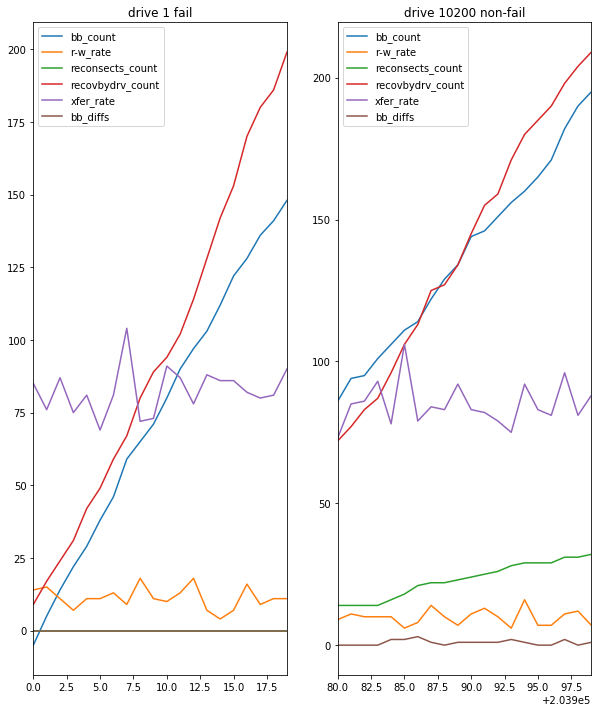

In [20]:
original_features = ['bb_count', 'r-w_rate', 'reconsects_count',
       'recovbydrv_count', 'xfer_rate', 'bb_diffs']

fig, axes = plt.subplots(nrows=1, ncols=2)
 # failed disk
ts_data.loc[ts_data['d_id']==1,original_features].plot(figsize=(10,12), title='drive '+str(1)+' fail', ax=axes[0])

num_drives = ts_data['d_id'].unique().shape[0]
#num_drives

 # non-failed disk
ts_data.loc[ts_data['d_id']==num_drives,original_features].plot(figsize=(10,12), title='drive '+str(num_drives)+' non-fail', ax=axes[1])
plt.legend()

#randomly chose 2 disks - fail and non-failed, we can see that bb_count is higher on non-failed results

# Engineer the time-series features

For each Create the aggregated features (mean, median, variance, minimum and naximum):
* for each sn
* for each feature
* for each aggregation type
        aggregate the 20 daily samples into one aggregated sample  

In [21]:
#Q1

#calculating functions & merging all together

featured_data = featured_data.drop(columns=['time'])
mean = featured_data.groupby(['d_id','fail']).mean()
median = featured_data.groupby(['d_id','fail']).median()
variance = featured_data.groupby(['d_id','fail']).var()
minimum = featured_data.groupby(['d_id','fail']).min()
maximum = featured_data.groupby(['d_id','fail']).max()

output = pd.merge(mean,median,on=['d_id','fail'],suffixes=('_mean', '_median'))
output = pd.merge(output,variance,on=['d_id','fail'],suffixes=('_median','_variance'))
output = pd.merge(output,minimum,on=['d_id','fail'],suffixes=('_variance', '_minimum'))
output = pd.merge(output,maximum.add_suffix('_maximum'),on=['d_id','fail'],suffixes=('', '_maximum'))

output.head()





,,bb_count_mean,r-w_rate_mean,reconsects_count_mean,recovbydrv_count_mean,xfer_rate_mean,bb_diffs_mean,bb_count_median,r-w_rate_median,reconsects_count_median,recovbydrv_count_median,...,reconsects_count_minimum,recovbydrv_count_minimum,xfer_rate_minimum,bb_diffs_minimum,bb_count_maximum,r-w_rate_maximum,reconsects_count_maximum,recovbydrv_count_maximum,xfer_rate_maximum,bb_diffs_maximum
d_id,fail,,,,,,,,,,,,,,,,,,,,,
1,True,75.05,11.30,0.00,96.75,82.60,0.0,75.5,11.0,0.0,91.5,...,0,9,69,0,148,18,0,199,104,0
2,True,102.35,18.80,3.00,121.70,82.55,0.0,97.0,18.0,3.0,124.0,...,3,35,69,0,173,27,3,209,100,0
3,True,153.30,20.00,5.00,166.00,93.90,0.0,152.0,21.5,5.0,170.0,...,5,51,77,0,249,28,5,284,104,0
4,True,96.05,20.00,-2.00,154.90,112.85,0.0,99.0,19.5,-2.0,151.5,...,-2,3,94,0,202,25,-2,322,134,0
5,True,140.45,9.55,29.05,149.15,94.75,2.5,146.0,9.5,31.5,145.0,...,6,42,71,0,230,20,53,265,117,7


# Load the cofiguration data

In [22]:
#static data - configuration

conf_file_path = get_file_path('conf_data.csv')
conf_data = pd.read_csv(conf_file_path)
conf_data.head()

,d_id,age,capacity,model,fail
0,1,15,1TB,Hitachi,True
1,2,23,1TB,Fujitsu,True
2,3,23,1TB,Seagate,True
3,4,14,1TB,Hitachi,True
4,5,18,600GB,Hitachi,True


# Look at the features\labels distribution

<Figure size 432x288 with 0 Axes>

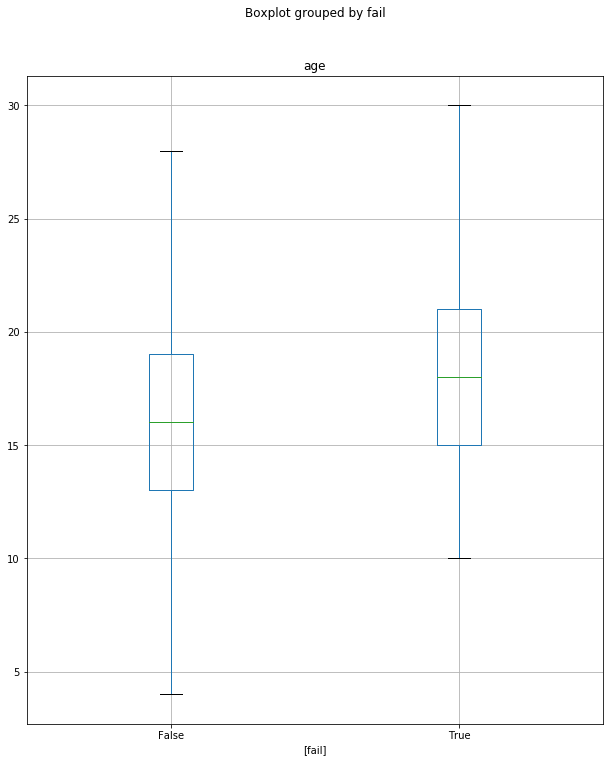

In [23]:
#failed disks are older (green line - median)


plt.figure()
conf_data[['age', 'fail']].boxplot(by='fail', figsize=(10,12), sym='')

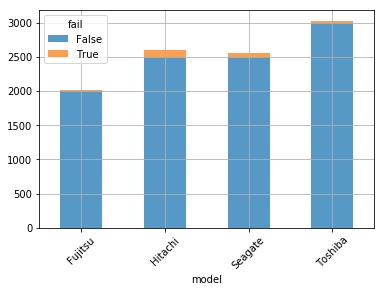

In [24]:
#Hitachi vendor - high score of failures

g = conf_data.groupby(["model", "fail"])['d_id'].count().unstack('fail')
g.plot(kind="bar", stacked=True, grid=True, alpha=0.75, rot=45)

# Handle categorical data 

For the decision tree algorithm, map the categorical features to numeric with:
* "Change_capacity" function for "capacity" column
* "pd.get_dummies" function for "model" column


In [25]:
#Q2

#getDummies - mask of 0 or 1 for some property

def change_capacity(data):
    # A function that receives a data frame and a column name as input and map the categorical capacity feature to numeric 
    di = dict(zip(data["capacity"].unique(), [1000, 600, 300]))

    new_data = data.replace({"capacity": di}, inplace=False)
    return new_data


In [26]:

new_conf_data = change_capacity(conf_data)
new_conf_data =pd.get_dummies(new_conf_data,columns=["model"]) 

new_conf_data.head()

,d_id,age,capacity,fail,model_Fujitsu,model_Hitachi,model_Seagate,model_Toshiba
0,1,15,1000,True,0,1,0,0
1,2,23,1000,True,1,0,0,0
2,3,23,1000,True,0,0,1,0
3,4,14,1000,True,0,1,0,0
4,5,18,600,True,0,1,0,0


# Merge the aggregated time-series and the configuration datasets

In [27]:
#Q3

#merging our data from Q1 with our configuration data from Q2

data = pd.merge(output,new_conf_data,on='d_id');
data_train = data.drop(columns=['d_id','fail']) 
data_fail = data[['fail']]

print(data_train)
print(data_fail)
data

       bb_count_mean  r-w_rate_mean  reconsects_count_mean  \
0              75.05          11.30                   0.00   
1             102.35          18.80                   3.00   
2             153.30          20.00                   5.00   
3              96.05          20.00                  -2.00   
4             140.45           9.55                  29.05   
...              ...            ...                    ...   
10195         110.00           8.55                  12.15   
10196         123.40          15.20                  53.55   
10197          52.95          11.15                  31.70   
10198          89.50           6.90                  50.25   
10199         137.60           9.75                  23.10   

       recovbydrv_count_mean  xfer_rate_mean  bb_diffs_mean  bb_count_median  \
0                      96.75           82.60           0.00             75.5   
1                     121.70           82.55           0.00             97.0   
2              

,d_id,bb_count_mean,r-w_rate_mean,reconsects_count_mean,recovbydrv_count_mean,xfer_rate_mean,bb_diffs_mean,bb_count_median,r-w_rate_median,reconsects_count_median,...,recovbydrv_count_maximum,xfer_rate_maximum,bb_diffs_maximum,age,capacity,fail,model_Fujitsu,model_Hitachi,model_Seagate,model_Toshiba
0,1,75.05,11.30,0.00,96.75,82.60,0.00,75.5,11.0,0.0,...,199,104,0,15,1000,True,0,1,0,0
1,2,102.35,18.80,3.00,121.70,82.55,0.00,97.0,18.0,3.0,...,209,100,0,23,1000,True,1,0,0,0
2,3,153.30,20.00,5.00,166.00,93.90,0.00,152.0,21.5,5.0,...,284,104,0,23,1000,True,0,0,1,0
3,4,96.05,20.00,-2.00,154.90,112.85,0.00,99.0,19.5,-2.0,...,322,134,0,14,1000,True,0,1,0,0
4,5,140.45,9.55,29.05,149.15,94.75,2.50,146.0,9.5,31.5,...,265,117,7,18,600,True,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,10196,110.00,8.55,12.15,146.40,87.10,0.65,115.5,8.0,13.5,...,279,103,2,16,1000,False,0,0,1,0
10196,10197,123.40,15.20,53.55,58.55,82.50,4.80,127.0,15.5,53.0,...,82,98,10,25,600,False,0,1,0,0
10197,10198,52.95,11.15,31.70,218.70,70.65,2.40,56.5,10.0,32.0,...,380,89,7,23,300,False,0,1,0,0
10198,10199,89.50,6.90,50.25,151.80,62.40,4.10,88.0,7.5,50.0,...,267,76,8,13,600,False,0,0,1,0


# Select the 10 most informative features and transform the data

In [28]:
#Q4

#f_classif function used for classification problem (fail - true or false)
#k=10, we want 10 best features
#X_train = data_train.values, choose the best features
#y_train = data_fail.values.ravel(), fail or not

selection = SelectKBest(score_func=f_classif,k=10).fit_transform(data_train.values,data_fail.values.ravel()) 
print(selection)





[[ 11.3    0.    82.6  ...  69.    18.   104.  ]
 [ 18.8    3.    82.55 ...  69.    27.   100.  ]
 [ 20.     5.    93.9  ...  77.    28.   104.  ]
 ...
 [ 11.15  31.7   70.65 ...  55.    17.    89.  ]
 [  6.9   50.25  62.4  ...  49.    12.    76.  ]
 [  9.75  23.1   84.95 ...  73.    16.   106.  ]]


# Train a Decision tree classifier 

Since we are learning and testing on the same set we will limit the maximum depth parameter to 5 to prevent overfitting

In [29]:
#Q5

#init decision tree with max_depth=5 (our testing and training sets are identical, prevent overfitting) 
#we train our tree on the best features set with y fail results (X_train,y_train)

classifier = DecisionTreeClassifier(max_depth=5).fit(selection,data_fail.values.ravel())
classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

# Make the prediction and plot the confusion matrix
https://en.wikipedia.org/wiki/Confusion_matrix

* Change "max_depth" paramter to see what happens to model results


In [30]:
#Q6

#predict results, we want to predict our training set results

pred = classifier.predict(selection)
print(confusion_matrix(data_fail.values.ravel(), pred))

[[9980   20]
 [  50  150]]
